# 04_error_analysis.ipynb
# Análise de Erros: Baseline (TF-IDF + Regressão Logística)
# Objetivo:

Investigar o comportamento do modelo baseline de classificação de fake news (TF-IDF + Regressão Logística), por meio da análise de erros de predição e da identificação dos principais padrões linguísticos que influenciam suas decisões.

# O que ele faz:

1. Matriz de confusão, permitindo avaliar a distribuição dos acertos e erros entre as classes.

2. Inspeção de exemplos representativos de:

- Falsos positivos
- Falsos negativos

3. Interpretabilidade global do modelo
4. Análise qualitativa do comportamento do modelo na conclusão

In [7]:
# 0) Importação das bibliotecas e carregamento dos dados

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
)

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [8]:
# Conteúdo base (igual ao baseline)

train["content"] = train["title"].fillna("") + " " + train["text"].fillna("")
test["content"]  = test["title"].fillna("")  + " " + test["text"].fillna("")

train = train.drop_duplicates(subset=["title", "text"]).reset_index(drop=True)

X = train["content"]
y = train["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 3),
        max_features= 70000,
        min_df=2,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        C= 3.0,
        n_jobs=-1
    ))
])

pipeline.fit(X_train, y_train)

val_proba = pipeline.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.1, 0.9, 81)
best_t = 0.5
best_f1 = -1

for t in thresholds:
    val_pred_t = (val_proba >= t).astype(int)
    f1 = f1_score(y_val, val_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"Melhor threshold (val): {best_t:.3f}")
print(f"F1 (val) no melhor threshold: {best_f1:.6f}")

Melhor threshold (val): 0.400
F1 (val) no melhor threshold: 0.986977


In [9]:
val_pred_best = (val_proba >= best_t).astype(int)
print("\nClassification report (val):")
print(classification_report(y_val, val_pred_best, digits=4))


Classification report (val):
              precision    recall  f1-score   support

           0     0.9976    0.9941    0.9959      3400
           1     0.9815    0.9925    0.9870      1069

    accuracy                         0.9937      4469
   macro avg     0.9896    0.9933    0.9914      4469
weighted avg     0.9938    0.9937    0.9937      4469



<Figure size 600x500 with 0 Axes>

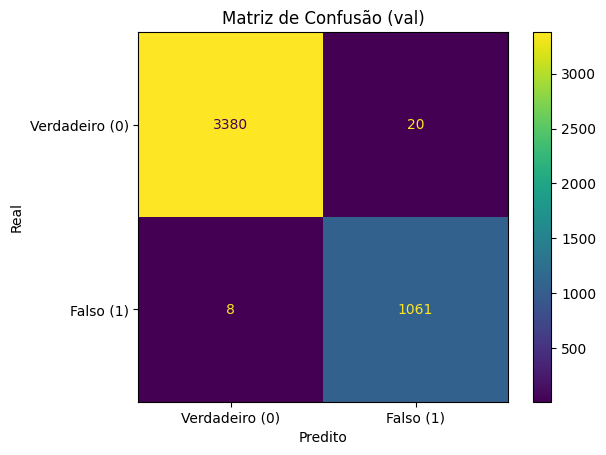

In [10]:
# 1) MATRIZ DE CONFUSÃO com rótulos (heatmap)

cm = confusion_matrix(y_val, val_pred_best, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Verdadeiro (0)", "Falso (1)"]
)

plt.figure(figsize=(6, 5))
disp.plot(cmap="viridis", values_format="d")
plt.title("Matriz de Confusão (val)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

In [11]:
# 2) MOSTRAR EXEMPLOS (FP e FN)
# FP: Real 0 (true) mas Pred 1 (fake)
# FN: Real 1 (fake) mas Pred 0 (true)

val_df = pd.DataFrame({
    "content": X_val.values,
    "y_true": y_val.values,
    "proba_fake": val_proba,
    "y_pred": val_pred_best
})

fp = val_df[(val_df["y_true"] == 0) & (val_df["y_pred"] == 1)].copy()
fn = val_df[(val_df["y_true"] == 1) & (val_df["y_pred"] == 0)].copy()

print("\nQtd de Falsos Positivos (Real=0, Pred=1):", len(fp))
print("Qtd de Falsos Negativos (Real=1, Pred=0):", len(fn))


Qtd de Falsos Positivos (Real=0, Pred=1): 20
Qtd de Falsos Negativos (Real=1, Pred=0): 8


In [12]:
# Função auxiliar para imprimir exemplos
def mostrar_exemplos(df_erros, titulo, n=5, ordenar_por="proba_fake", desc=True):
    print("\n" + "="*70)
    print(titulo)
    print("="*70)

    if df_erros.empty:
        print("Nenhum exemplo encontrado.")
        return

    df_show = df_erros.sort_values(by=ordenar_por, ascending=not desc).head(n)

    for i, row in enumerate(df_show.itertuples(), 1):
        texto = row.content
        texto = re.sub(r"\s+", " ", str(texto)).strip()

        # Mostrar só um trecho pra não poluir
        trecho = texto[:350] + ("..." if len(texto) > 350 else "")

        print(f"\nExemplo {i}")
        print(f"  y_true: {row.y_true} | y_pred: {row.y_pred} | proba_fake: {row.proba_fake:.4f}")
        print(f"  Texto (trecho): {trecho}")


# Mostra os "erros mais confiantes" (pior caso)

mostrar_exemplos(fp, "FALSOS POSITIVOS (Verdadeiro->Predito como Falso) | mais confiantes", n=5)
mostrar_exemplos(fn, "FALSOS NEGATIVOS (Falso->Predito como Verdadeiro) | mais confiantes", n=5)


FALSOS POSITIVOS (Verdadeiro->Predito como Falso) | mais confiantes

Exemplo 1
  y_true: 0 | y_pred: 1 | proba_fake: 0.8892
  Texto (trecho): Transcript of Trump video statement in response to lewd remarks about women WASHINGTON (Reuters) - U.S. Republican presidential nominee Donald Trump issued a video statement early on Saturday in response to the disclosure of a 2005 videotape of him making lewd remarks about women. Here is a text of his statement: “I’ve never said I’m a perfect pers...

Exemplo 2
  y_true: 0 | y_pred: 1 | proba_fake: 0.8185
  Texto (trecho): Hillary Clinton's 'What Happened' fends off O'Reilly in bestsellers (Reuters) - “What Happened,” Hillary Clinton’s memoir of her unsuccessful bid to win the 2016 U.S. presidential election, topped the U.S. non-fiction bestsellers list on Thursday, fending off a challenge from the latest book by former Fox News anchor Bill O’Reilly. Data released by...

Exemplo 3
  y_true: 0 | y_pred: 1 | proba_fake: 0.8107
  Texto (trecho): T

In [13]:
# 3) INTERPRETABILIDADE GLOBAL (top termos por coeficiente)

# Para Logistic Regression com TF-IDF, dá pra usar os coeficientes:
# coef > 0 puxa para classe 1 (Fake)
# coef < 0 puxa para classe 0 (True)

tfidf = pipeline.named_steps["tfidf"]
clf   = pipeline.named_steps["clf"]

feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_.ravel()

# Top termos que mais empurram para Fake (classe 1)
top_fake_idx = np.argsort(coefs)[-20:][::-1]
# Top termos que mais empurram para True (classe 0) => coef mais negativo
top_true_idx = np.argsort(coefs)[:20]

top_fake = pd.DataFrame({
    "termo": feature_names[top_fake_idx],
    "coef": coefs[top_fake_idx]
})

top_true = pd.DataFrame({
    "termo": feature_names[top_true_idx],
    "coef": coefs[top_true_idx]
})

print("\nTop 20 termos que mais puxam para FALSO (classe 1):")
display(top_fake)


Top 20 termos que mais puxam para FALSO (classe 1):


,termo,coef
0,video,13.719431
1,read,8.106812
2,image,7.382955
3,featured image,7.268890
4,just,7.265320
5,featured,7.218037
6,obama,6.953747
7,watch,6.256291
8,hillary,5.934072
9,gop,5.904516


In [14]:
print("\nTop 20 termos que mais puxam para VERDADEIRO (classe 0):")
display(top_true)


Top 20 termos que mais puxam para VERDADEIRO (classe 0):


,termo,coef
0,reuters,-18.413772
1,said,-13.084099
2,washington reuters,-9.008859
3,washington,-5.963282
4,wednesday,-5.531319
5,president donald,-5.105814
6,president donald trump,-5.098516
7,republican,-4.974064
8,tuesday,-4.927303
9,thursday,-4.842147


### Observação sobre os Gráficos:
O sinal indica a DIREÇÃO da influência e o valor absoluto indica a FORÇA.
#
- Para a classe Fake são usados os coeficientes positivos diretamente.
- Para a classe True é usada a magnitude (valor absoluto dos coeficientes), apenas para facilitar a visualização comparativa, já que os coeficientes dessa classe são negativos.

Assim é possível identificar quais palavras mais contribuem para cada classe.

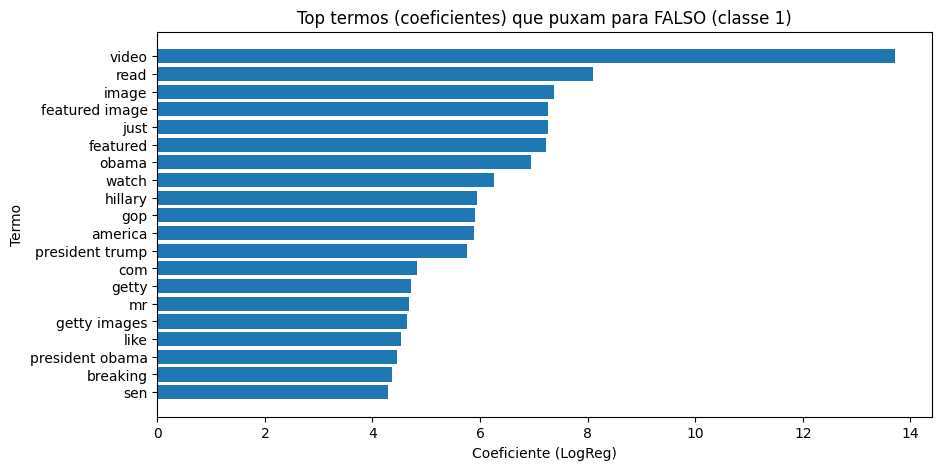

In [15]:
plt.figure(figsize=(10, 5))
plt.barh(top_fake["termo"][::-1], top_fake["coef"][::-1])
plt.title("Top termos (coeficientes) que puxam para FALSO (classe 1)")
plt.xlabel("Coeficiente (LogReg)")
plt.ylabel("Termo")
plt.show()

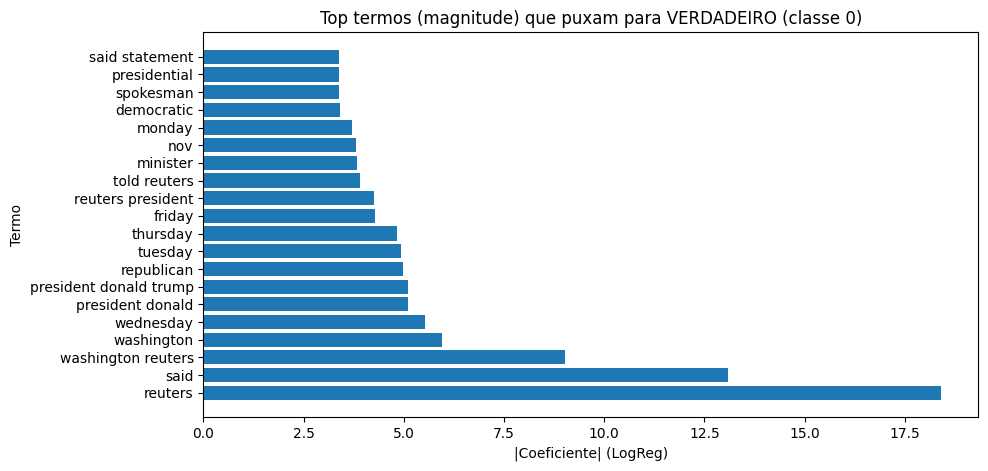

In [16]:
plt.figure(figsize=(10, 5))
plt.barh(top_true["termo"], np.abs(top_true["coef"]))  # abs só pra visualizar magnitude
plt.title("Top termos (magnitude) que puxam para VERDADEIRO (classe 0)")
plt.xlabel("|Coeficiente| (LogReg)")
plt.ylabel("Termo")
plt.show()

# Conclusão

A análise de erros confirma que o modelo baseline apresenta desempenho elevado, com baixa taxa de confusão entre as classes. Os falsos positivos concentram-se em notícias legítimas com forte conteúdo político e vocabulário semelhante ao de textos sensacionalistas, enquanto os falsos negativos correspondem, em geral, a notícias falsas com estrutura mais formal, que imitam o estilo jornalístico.

A inspeção dos coeficientes revela dependência de marcadores lexicais superficiais, como termos de mídia e nomes políticos associados à classe falsa, e expressões institucionais (ex.: Reuters, said, Washington) associadas à classe verdadeira, o que evidencia a presença de viés de fonte editorial no processo de aprendizagem.

Esses achados reforçam a importância das etapas posteriores de modelagem mais robusta, que incorporam sinais adicionais de estilo textual (como n-grams de caracteres), reduzindo a dependência exclusiva de pistas lexicais superficiais e favorecendo melhor capacidade de generalização.